<a href="https://colab.research.google.com/github/DarthCoder501/ML-AI-Projects/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:01<00:00, 90.2MB/s]
100% 149M/149M [00:01<00:00, 91.4MB/s]


In [3]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [4]:
tr_df = get_class_paths('/content/Training')

In [5]:
tr_df

,Class Path,Class
0,/content/Training/pituitary/Tr-pi_0942.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_0797.jpg,pituitary
2,/content/Training/pituitary/Tr-pi_0448.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_0222.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_0629.jpg,pituitary
...,...,...
5707,/content/Training/glioma/Tr-gl_0915.jpg,glioma
5708,/content/Training/glioma/Tr-gl_1212.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0856.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0340.jpg,glioma


In [6]:
ts_df = get_class_paths('/content/Testing')

In [7]:
ts_df

,Class Path,Class
0,/content/Testing/pituitary/Te-pi_0227.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0032.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0191.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0037.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0187.jpg,pituitary
...,...,...
1306,/content/Testing/glioma/Te-gl_0107.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0112.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0197.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0038.jpg,glioma


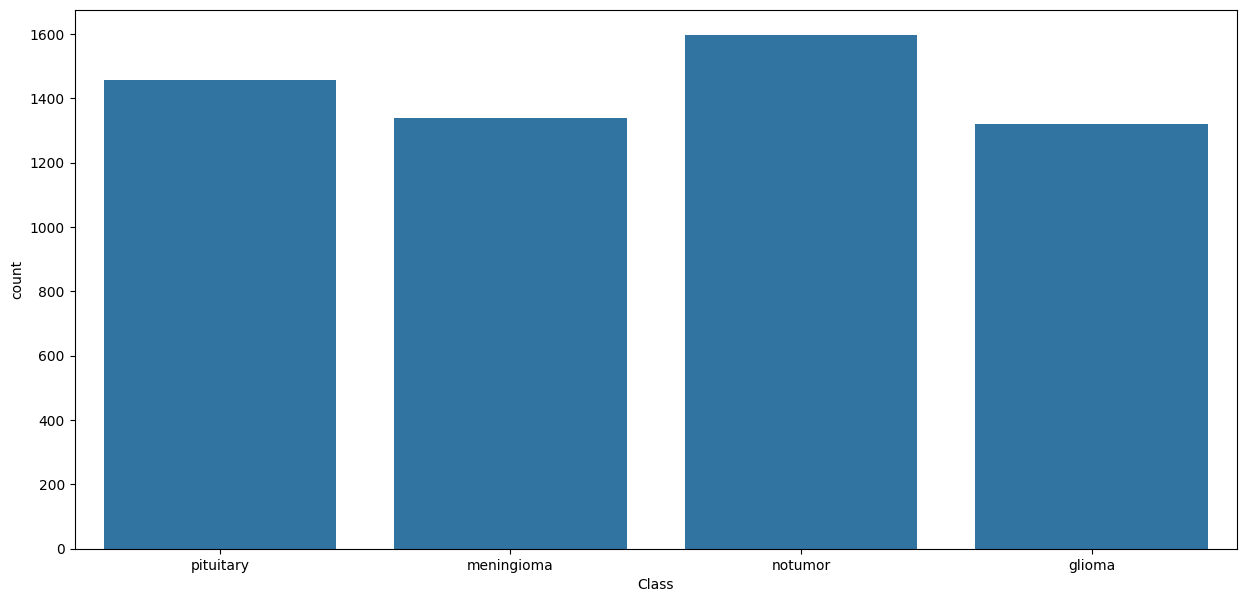

In [8]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, x=tr_df["Class"])

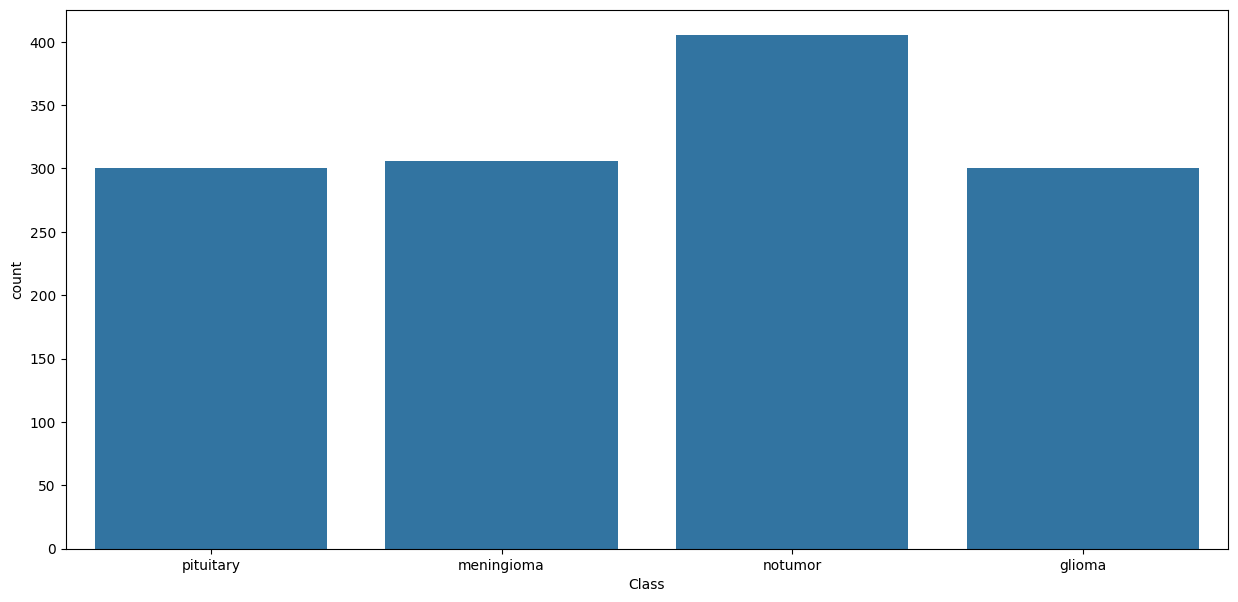

In [9]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, x=ts_df["Class"])

In [10]:
!pip install tensorflow

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
valid_df, ts_df = train_test_split(ts_df, test_size=0.5, stratify=ts_df['Class'])

In [13]:
valid_df

,Class Path,Class
60,/content/Testing/pituitary/Te-pi_0126.jpg,pituitary
197,/content/Testing/pituitary/Te-pi_0033.jpg,pituitary
486,/content/Testing/meningioma/Te-me_0124.jpg,meningioma
217,/content/Testing/pituitary/Te-pi_0250.jpg,pituitary
1001,/content/Testing/notumor/Te-no_0170.jpg,notumor
...,...,...
12,/content/Testing/pituitary/Te-pi_0035.jpg,pituitary
185,/content/Testing/pituitary/Te-pi_0162.jpg,pituitary
943,/content/Testing/notumor/Te-no_0148.jpg,notumor
200,/content/Testing/pituitary/Te-pi_0279.jpg,pituitary


In [14]:
ts_df

,Class Path,Class
214,/content/Testing/pituitary/Te-pi_0019.jpg,pituitary
146,/content/Testing/pituitary/Te-pi_0048.jpg,pituitary
458,/content/Testing/meningioma/Te-me_0252.jpg,meningioma
182,/content/Testing/pituitary/Te-pi_0272.jpg,pituitary
1279,/content/Testing/glioma/Te-gl_0204.jpg,glioma
...,...,...
304,/content/Testing/meningioma/Te-me_0216.jpg,meningioma
482,/content/Testing/meningioma/Te-me_0193.jpg,meningioma
193,/content/Testing/pituitary/Te-pi_0112.jpg,pituitary
611,/content/Testing/notumor/Te-no_0043.jpg,notumor


In [15]:
batch_size = 32

img_size = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

ts_datagen = ImageDataGenerator(rescale=1/255)

In [16]:
tr_gen = image_generator.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

ts_gen = ts_datagen.flow_from_dataframe(ts_df, x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

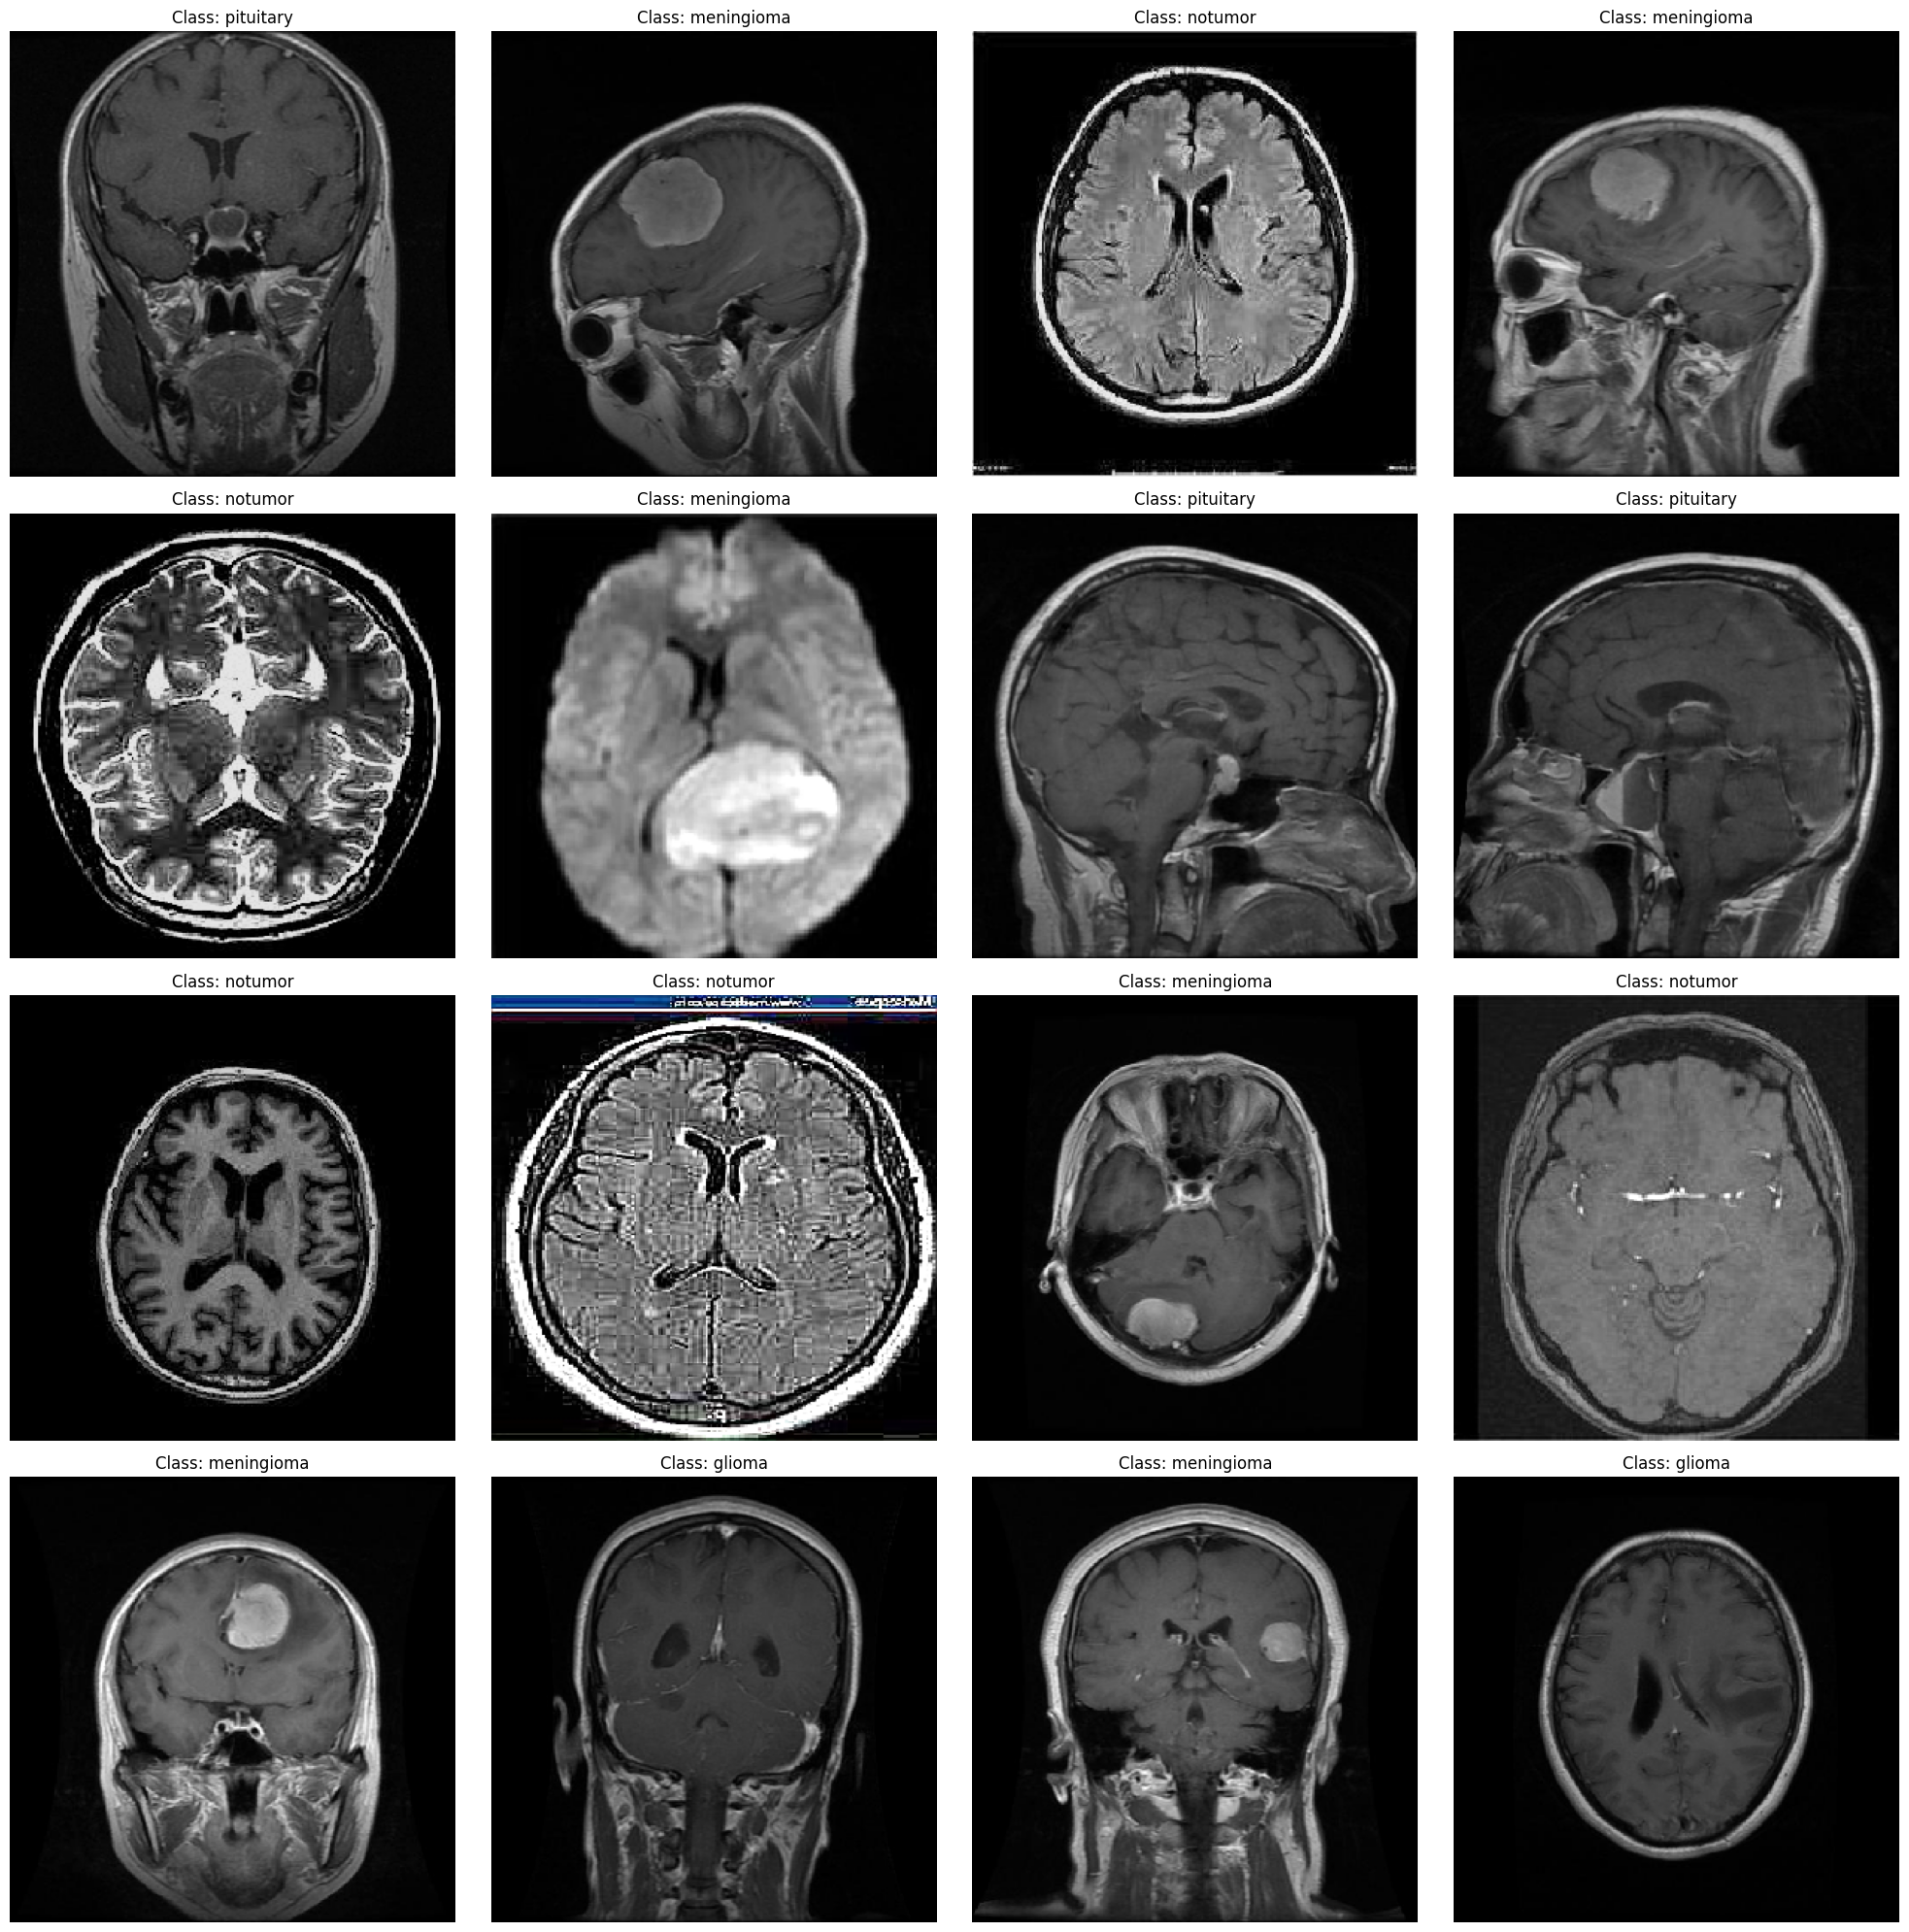

In [17]:
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get a list of the class names and indicies
  class_name = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_name[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show

In [18]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate = 0.3),
    Dense(128, activation='relu'),
    Dropout(rate = 0.25),
    Dense(4, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [20]:
hist = model.fit(tr_gen, validation_data=valid_gen, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.8054 - loss: 0.6264 - precision: 0.8411 - recall: 0.7286 - val_accuracy: 0.8718 - val_loss: 0.3642 - val_precision: 0.8742 - val_recall: 0.8702
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 782ms/step - accuracy: 0.9774 - loss: 0.0597 - precision: 0.9784 - recall: 0.9761 - val_accuracy: 0.9573 - val_loss: 0.1180 - val_precision: 0.9617 - val_recall: 0.9573
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 784ms/step - accuracy: 0.9935 - loss: 0.0219 - precision: 0.9942 - recall: 0.9935 - val_accuracy: 0.9847 - val_loss: 0.0632 - val_precision: 0.9847 - val_recall: 0.9832
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 782ms/step - accuracy: 0.9975 - loss: 0.0105 - precision: 0.9975 - recall: 0.9969 - val_accuracy: 0.9847 - val_loss: 0.0405 - val_precision: 0.9847 - val_recall: 0.9847
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 783ms/step - accuracy: 0.9965 - loss: 0.0122 - precision: 0.9965 - recall: 0.9960 - val_accuracy: 0.9832 - val_loss: 

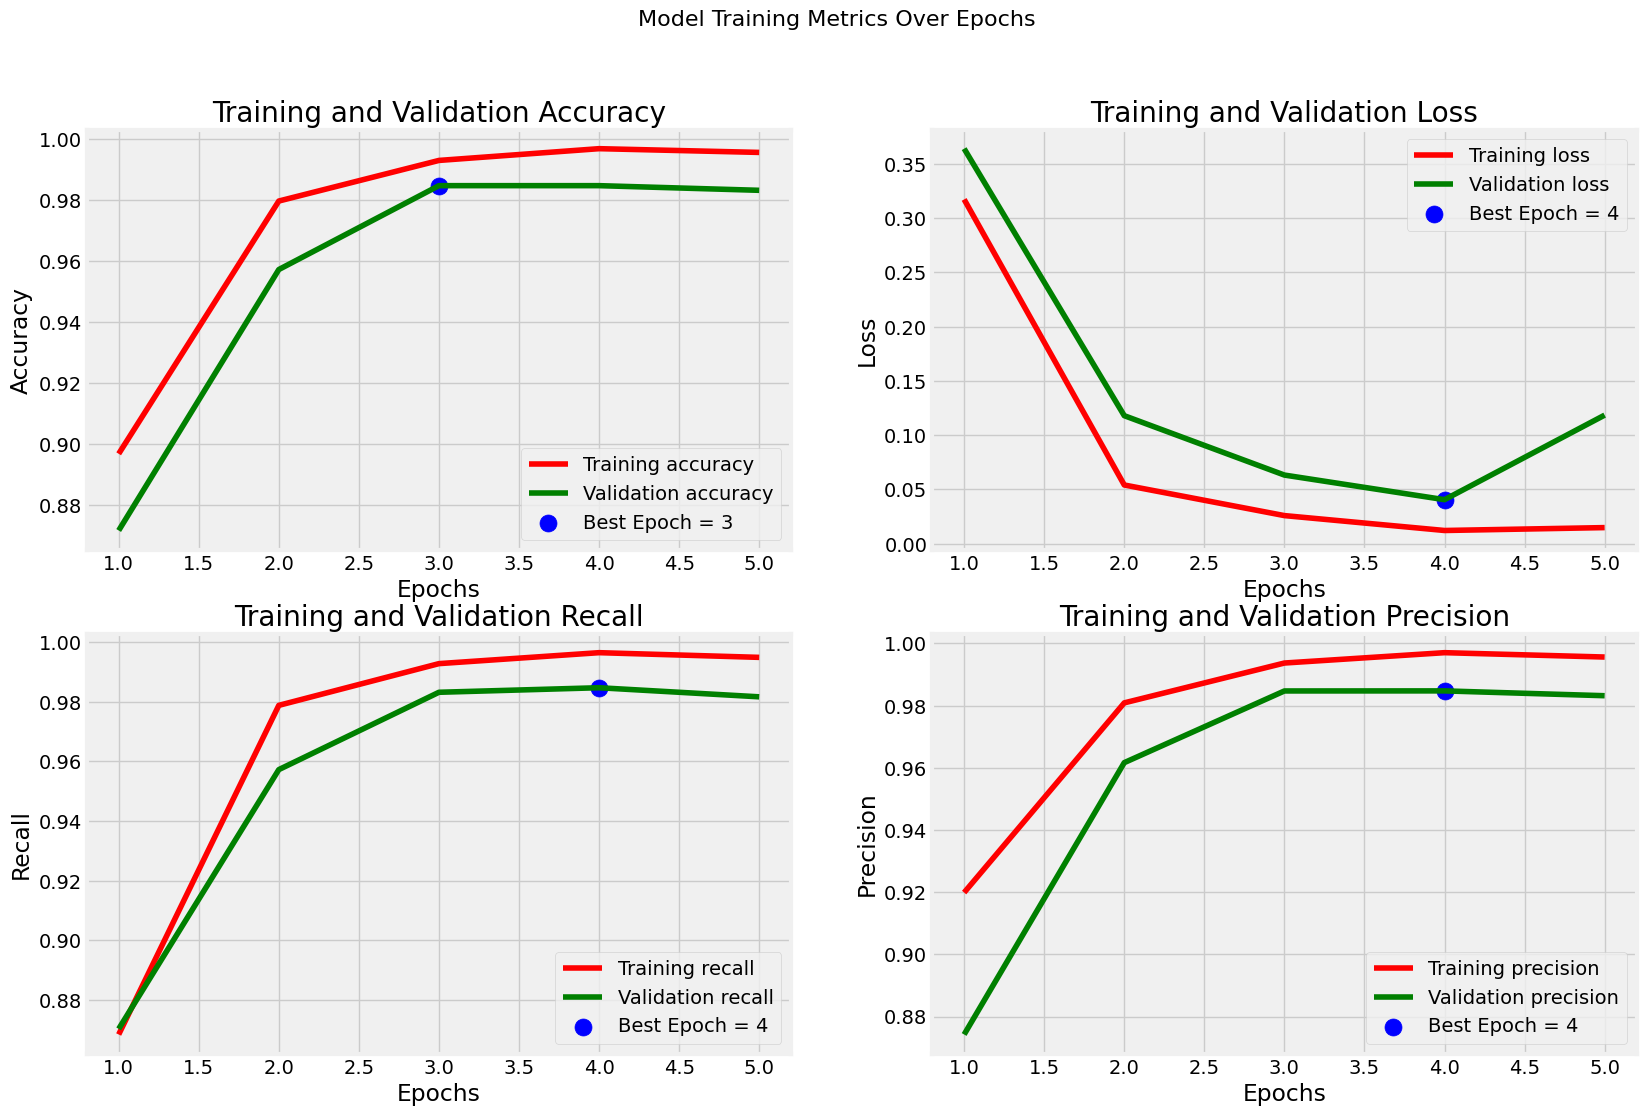

In [21]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'recall', 'precision']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find the best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best Epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [22]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f'Training Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}')
print(f'Test Loss: {test_score[0]:.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.9965 - loss: 0.0080 - precision: 0.9965 - recall: 0.9965
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.9812 - loss: 0.1397 - precision: 0.9812 - recall: 0.9812
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 1.0000 - loss: 3.6813e-05 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9728 - loss: 0.1263 - precision: 0.9728 - recall: 0.9728
Training Accuracy: 99.75%
Train Loss: 0.0060


Validation Accuracy: 98.32
Validation Loss: 0.1192


Test Accuracy: 97.71
Test Loss: 0.1136


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step


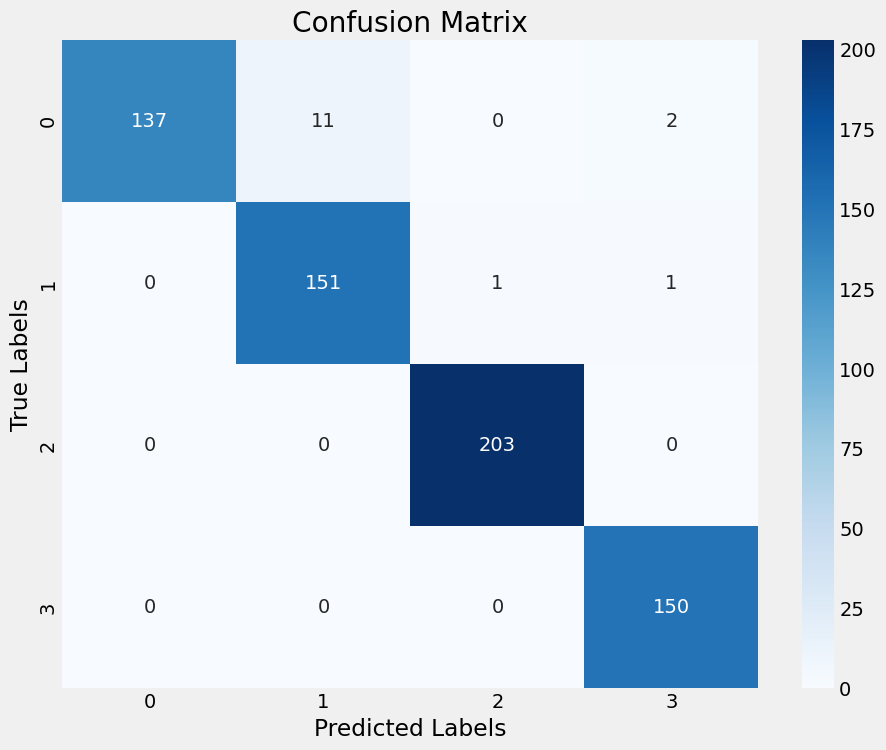

In [23]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma_tumor',
    1: 'meningioma_tumor',
    2: 'no_tumor',
    3: 'pituitary_tumor'
}

# Create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       150
           1       0.71      0.86      0.78       153
           2       0.92      0.97      0.94       203
           3       0.99      0.94      0.96       150

    accuracy                           0.88       656
   macro avg       0.89      0.87      0.88       656
weighted avg       0.90      0.88      0.88       656



In [24]:
from PIL import Image

def predict(img_path: str):
  # Get class labels
  labels = list(class_dict.keys())

  # Crate figure
  plt.figure(figsize=(10, 10))

  # Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f'Input MRI Image\nPredicted: {predicted_class}')

  # Plot prediction probailities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel('Probability', fontsize = 15)
  plt.title('Class Probabilities')

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f'\nPredicted tumor type: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


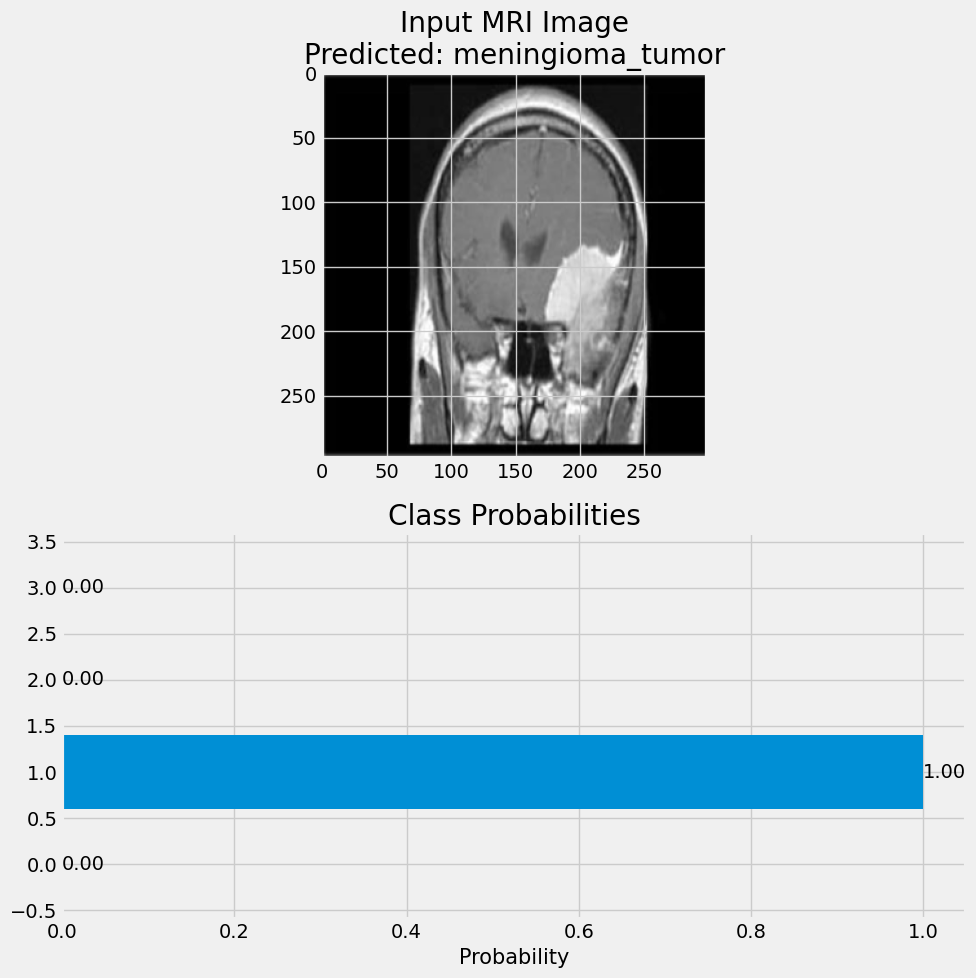


Predicted tumor type: meningioma_tumor


In [25]:
predict('/content/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


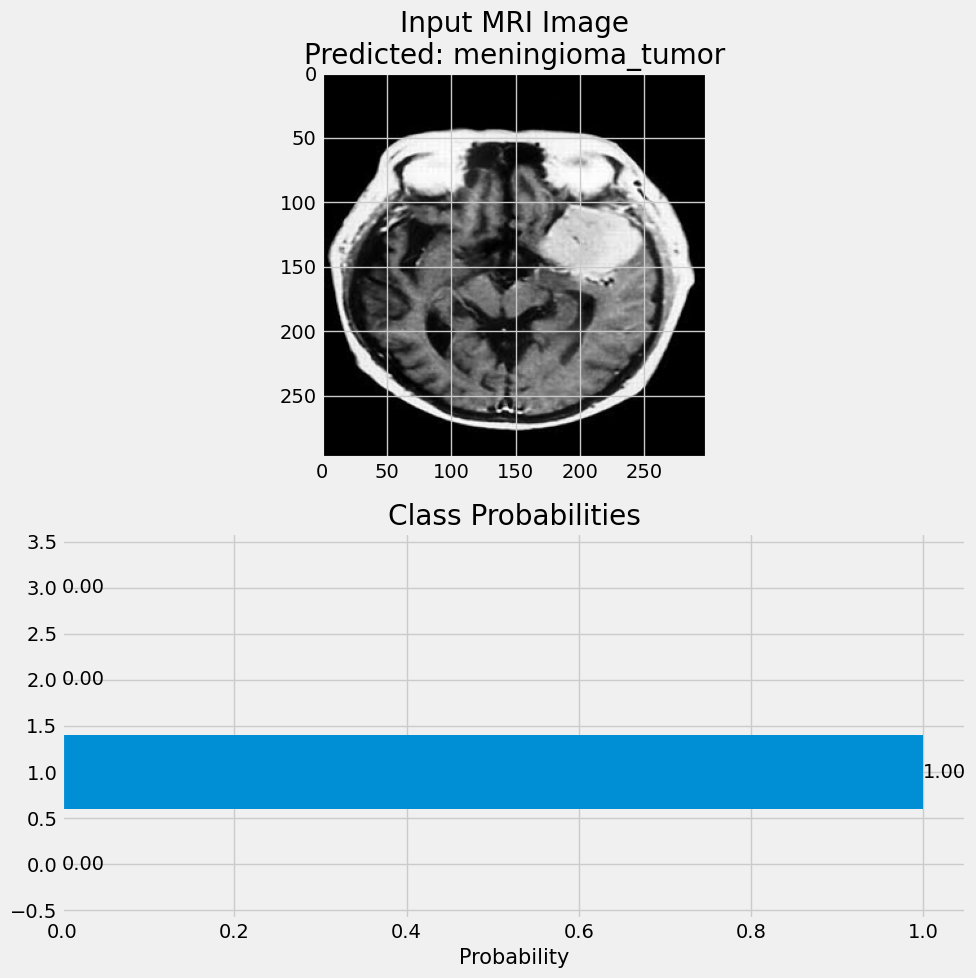


Predicted tumor type: meningioma_tumor


In [26]:
predict('/content/Testing/meningioma/Te-meTr_0005.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


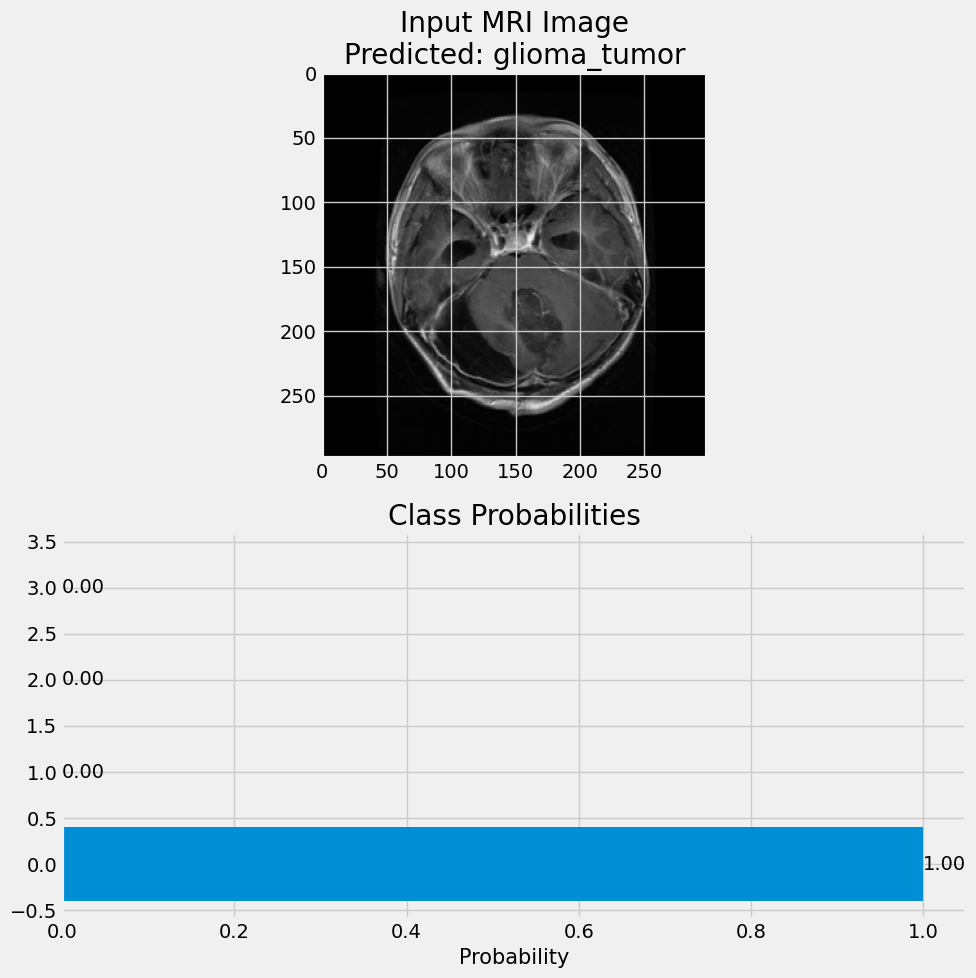


Predicted tumor type: glioma_tumor


In [27]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [28]:
model.save_weights('xception_model.weights.h5')

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [30]:
batch_size = 16

img_size = (224,224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

ts_datagen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size)

ts_gen = ts_datagen.flow_from_dataframe(ts_df, x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [31]:
# Create a Sequential model

cnn_model = Sequential()

# Add convolutional layers
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax')) # Output layer with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = cnn_model.fit(tr_gen, validation_data=valid_gen, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 145s 335ms/step - accuracy: 0.5449 - loss: 2.4445 - precision_1: 0.6734 - recall_1: 0.3611 - val_accuracy: 0.7176 - val_loss: 1.1006 - val_precision_1: 0.7633 - val_recall_1: 0.6794
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 162s 286ms/step - accuracy: 0.7989 - loss: 0.8573 - precision_1: 0.8212 - recall_1: 0.7641 - val_accuracy: 0.7786 - val_loss: 0.7842 - val_precision_1: 0.8027 - val_recall_1: 0.7145
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 293ms/step - accuracy: 0.8451 - loss: 0.6067 - precision_1: 0.8605 - recall_1: 0.8270 - val_accuracy: 0.8137 - val_loss: 0.6291 - val_precision_1: 0.8271 - val_recall_1: 0.7817
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 291ms/step - accuracy: 0.8826 - loss: 0.4646 - precision_1: 0.8934 - recall_1: 0.8720 - val_accuracy: 0.8137 - val_loss: 0.5765 - val_precision_1: 0.8306 - val_recall_1: 0.7863
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 290ms/step - accuracy: 0.8987 - loss: 0.4039 - precision_1: 0.9090 - recall_1: 0.8

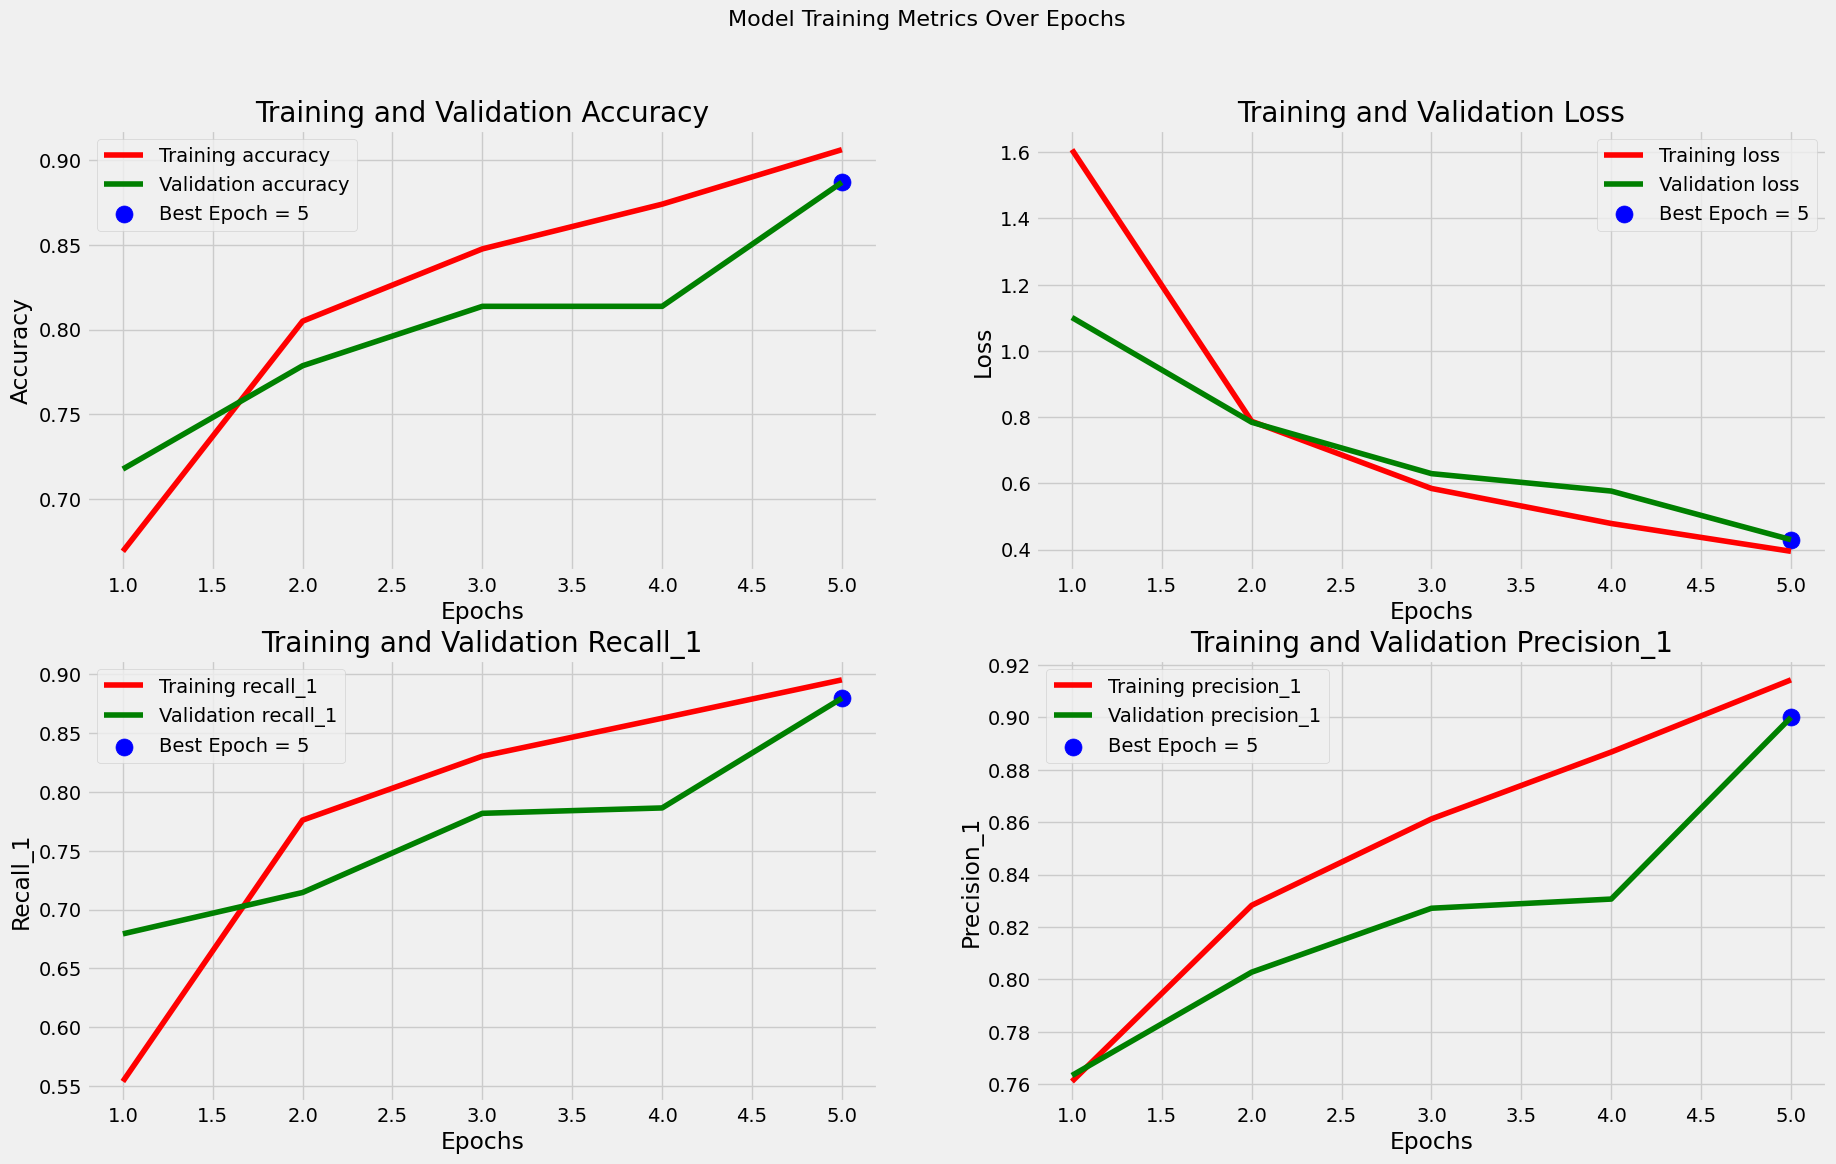

In [33]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'recall_1', 'precision_1']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find the best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best Epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [34]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f'Training Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}')
print(f'Test Loss: {test_score[0]:.4f}')

357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.9351 - loss: 0.3203 - precision_1: 0.9392 - recall_1: 0.9301
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.8873 - loss: 0.4309 - precision_1: 0.8980 - recall_1: 0.8801
 2/41 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8281 - loss: 0.3904 - precision_1: 0.8281 - recall_1: 0.8281 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8757 - loss: 0.4080 - precision_1: 0.8750 - recall_1: 0.8622
Training Accuracy: 93.52%
Train Loss: 0.3208


Validation Accuracy: 88.85
Validation Loss: 0.4248


Test Accuracy: 88.26
Test Loss: 0.4028


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


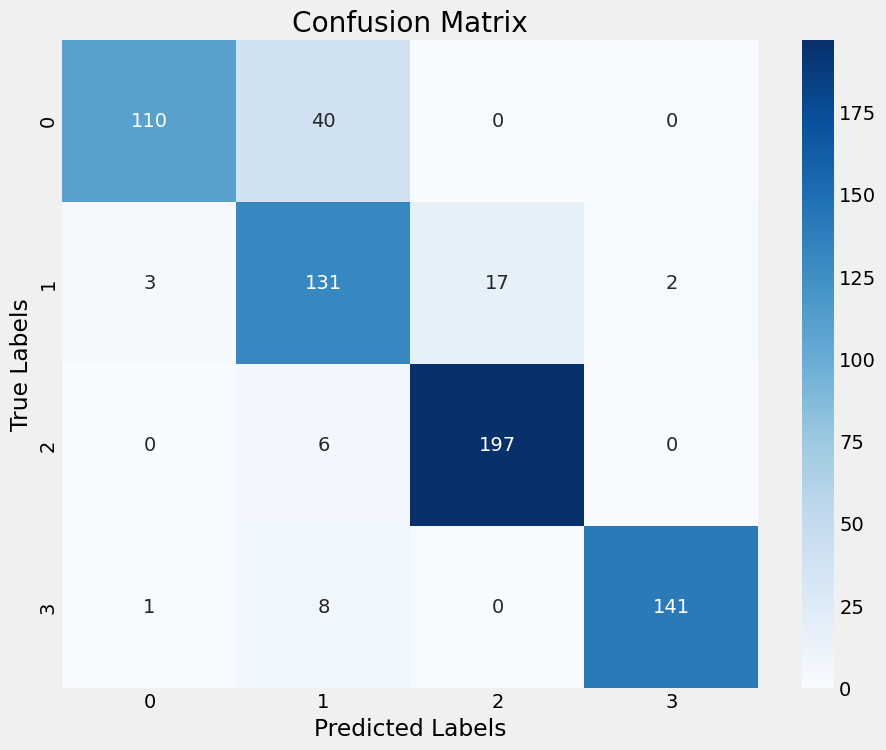

In [40]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma_tumor',
    1: 'meningioma_tumor',
    2: 'no_tumor',
    3: 'pituitary_tumor'
}

# Create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [42]:
print("Classification Report: ")
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       150
           1       0.71      0.86      0.78       153
           2       0.92      0.97      0.94       203
           3       0.99      0.94      0.96       150

    accuracy                           0.88       656
   macro avg       0.89      0.87      0.88       656
weighted avg       0.90      0.88      0.88       656



In [37]:
cnn_model.save("cnn_model.h5")

In [ ]:
!pip install streamlit pyngrok python-dotenv

In [ ]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata
import os

In [ ]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')

ngrok.set_auth_token(ngrok_token)

In [ ]:
def run_streamlit():
  os.system('streamlit run /content/app.py --server.port 8501')

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Recall, Precision
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

output_dir = "saliency_maps"
os.makedirs(output_dir, exist_ok = True)

def generate_explanation(img_path, model_prediction, confidence):
  prompt = f""" You are an expert neurologist. You are tasked with explaining a saliency map of a brain tumor MRI scan.
  The saliency map was generated by a deep learning model that was trained to classify brain tumors
  as either glimoa, meningioma, pituitary, or no tumor.

  The saliency map highlights the region of the image that the machine learning model is focusing more to make the prediction.

  The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

  In your response:
  - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the region highlighted
  in light cyan, those are the regions where the model is focusing on.
  - Explain possible resons why the model made the prediction it did.
  - Do not mention anything like 'The saliency map highlights the regions the model is focusing on, which are in light cyan'
  in your explanation.
  - Keep your explanation to 4 sentences max.

  Let's think step by step about this. Verify step by step.
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name='gemini-1.5-flash')
  response = model.generate_content([prompt, img])

  return response.text


def generate_saliency_map(model, img_array, class_index, img_size):
  with tf. GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    target_class = predictions[:, class_index]

  gradients = tape.gradient(target_class, img_tensor)
  gradients = tf.math.abs(gradients)
  gradients = tf.reduce_max(gradients, axis=-1)
  gradients = gradients.numpy().squeeze()

  # Resize gradients to match original image size
  gradients = cv2.resize(gradients, img_size)

  # Create a circular mask for the brain area
  center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
  radius = min(center[0], center[1]) - 10
  y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
  mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

  # Apply mask to gradients
  gradients = gradients * mask

  # Normalize only the brain area
  brain_gradients = gradients[mask]
  if brain_gradients.max() > brain_gradients.min():
    brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
  gradients[mask] = brain_gradients

  # Apply a higher threshold
  threshold = np.percentile(gradients[mask], 80)
  gradients[gradients < threshold] = 0

  # Apply more aggressive smoothing
  gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

  # Create a heatmap overlay with enhanced contrast
  heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  # Resize heatmap to match orginial image size
  heatmap = cv2.resize(heatmap, img_size)

  # Superimpose the heatmap on orginial image with increase opacity
  orginial_img = image.img_to_array(img)
  superimposed_img = heatmap * 0.7 + orginial_img + 0.3
  superimposed_img = superimposed_img.astype(np.uint8)

  img_path = os.path.join(output_dir, uploaded_file.name)
  with open(img_path, "wb") as f:
    f.write(uploaded_file.getbuffer())

  saliency_map_path = f"saliency_maps{uploaded_file.name}"

  # Save the saliency map
  cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

  return superimposed_img

def load_xception_model(model_path):
  img_shape =(299,299,3)
  base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=img_shape, pooling="max") # input_shape = img_size

  model = Sequential([
      base_model,
      Flatten(),
      Dropout(rate=0.3),
      Dense(128, activation="relu"),
      Dropout(rate=0.25),
      Dense(4, activation="softmax")
  ])

  model.build((None,) + img_shape)

  return model

st.title('Brain Tumor Classification')

st.write("Upload an image of a brain MRI scan to classify")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:

  selected_model = st.radio(
      "Selected Model",
      ("Transfer Learning - Xception", "Custom CNN")
  )

  if selected_model == "Transfer Learning - Xception":
    model = load_xception_model("/content/xception_model.weights.h5")
    img_size = (299, 299)
  else:
    model = load_model("/content/cnn_model.h5")
    img_size = (224, 224)

  labels = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
  img = image.load_img(uploaded_file, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_array)

  # Get the class with the highest probability
  class_index = np.argmax(prediction[0])
  result = labels[class_index]

  st.write(f"Predicted Class: {result}")
  st.write("Predictions")
  for label, prob in zip(labels, prediction[0]):
    st.write(f"{label}: {prob:.4f}")

  saliency_map = generate_saliency_map(model, img_array, class_index, img_size)
  col1, col2 = st.columns(2)
  with col1:
    st.image(uploaded_file, caption="Uploaded Image", use_container_width = True)
  with col2:
    st.image(saliency_map, caption="Saliency Map", use_container_width = True)

  saliency_map_path = f"saliency_maps{uploaded_file.name}"
  explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])

  st.write("## Explanation")
  st.write(explanation)

Overwriting app.py


In [ ]:
thread = Thread(target=run_streamlit)
thread.start()

In [ ]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)

print("Public URL: ", public_url)

In [ ]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

In [ ]:
%%writefile .env

GOOGLE_API_KEY = GOOGLE_API_KEY
